# Minimal AI Feature API Rollup Example
This notebook is intended as a bare bones example to show a straightforward case of:

* Pulling a result from the AI Feature API
* Loading the json payload into a GeoDataFrame
* Visualising the result


In [1]:
from pathlib import Path
import os
import json
import sys

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import shapely.wkt

sys.path.append("../")
from nearmap_ai.feature_api import FeatureApi
from nearmap_ai import constants, log, parcels

# Path to local API response cache
CACHE_DIR = Path("./cache")

# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

In [2]:
# Create instance of feature API to use existing python library
feature_api = FeatureApi(api_key=API_KEY, cache_dir=CACHE_DIR)

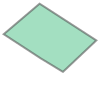

POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))


In [3]:
# Load a parcel boundary from test files
polygon = parcels.read_from_file(Path("../tests/data/test_parcels_2.csv")).iloc[5].geometry
display(polygon)
print(polygon)

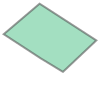

In [4]:
# Alternatively load your own boundary here
polygon = shapely.wkt.loads("POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))")
polygon

In [5]:
# Get the API payload for that polygon as a geodataframe
features_gdf, metadata_df, error_df = feature_api.get_features_gdf(polygon)
assert error_df is None

In [6]:
# Alternatively, load a payload from disk from your cache, or another source
with open("sample_payload.json", "r") as f:
    payload = json.load(f)
features_gdf, metadata_df = feature_api.payload_gdf(payload, 0)

<AxesSubplot:>

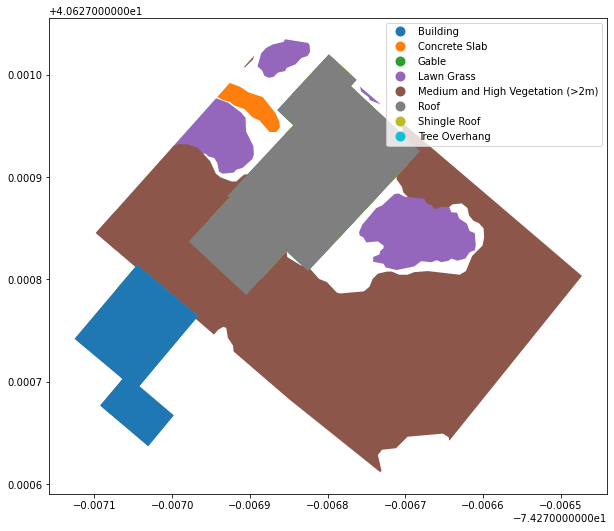

In [7]:
# Simple plot of features
features_gdf.plot("description", legend=True, figsize=(10,10))

In [8]:
# Filter out edge features based on default logic (ratios in parcel and minimum clipped areas)
filtered_features_gdf = parcels.filter_features_in_parcels(features_gdf)

<AxesSubplot:>

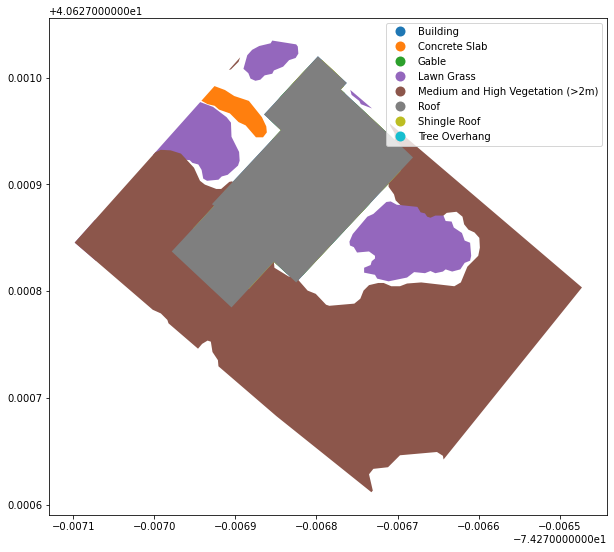

In [9]:
# Simple plot of features
filtered_features_gdf.plot("description", legend=True, figsize=(10,10))

In [10]:
filtered_features_gdf

,feature_id,class_id,description,confidence,parent_id,fidelity,area_sqm,area_sqft,clipped_area_sqm,clipped_area_sqft,unclipped_area_sqm,unclipped_area_sqft,attributes,survey_date,mesh_date,aoi_id,geometry,intersection_ratio
0,009b96fe-109b-5be4-b4af-32fe1a79d101,a2e4ae39-8a61-5515-9d18-8900aa6e6072,Building,0.994141,,0.890658,291.0,3132,289.0,3111,291.0,3132,[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e...,2021-10-19,2021-03-02,0,"POLYGON ((-74.27693 40.62788, -74.27684 40.627...",0.993127
1,400d5479-ff13-5a2d-9e4d-0ba9c2e163dd,59c6e27e-6ef2-5b5c-90e7-31cfca78c0c2,Gable,0.986328,ffc3ebd6-c42b-5a8c-b9af-72a85c3a11c7,NaN,280.7,3022,279.1,3004,280.7,3022,[],2021-10-19,2021-03-02,0,"POLYGON ((-74.27680 40.62802, -74.27679 40.628...",0.994300
2,407c79f5-9dd8-5650-9e80-8818b11af4e6,68dc5061-5842-4a17-8073-e278a91b607d,Lawn Grass,0.887670,,NaN,42.6,459,42.6,459,176.4,1899,[],2021-10-19,2021-03-02,0,"MULTIPOLYGON (((-74.27691 40.62796, -74.27690 ...",0.241497
3,560b476b-456d-52e2-aca0-958927a9588b,8e9448bd-4669-5f46-b8f0-840fee25c34c,Tree Overhang,0.977578,ffc3ebd6-c42b-5a8c-b9af-72a85c3a11c7,NaN,75.2,810,75.2,810,75.2,810,[],2021-10-19,2021-03-02,0,"MULTIPOLYGON (((-74.27683 40.62781, -74.27683 ...",1.000000
4,61868501-0555-5a8d-883f-668c48b68171,290897be-078b-4948-97aa-755289a67a29,Concrete Slab,0.896484,,NaN,14.3,154,14.3,154,23.9,257,[],2021-10-19,2021-03-02,0,"POLYGON ((-74.27686 40.62795, -74.27686 40.627...",0.598326
5,7e2340b1-3638-5e1b-b83e-cb0de5b6df63,dfd8181b-80c9-4234-9d05-0eef927e3aca,Medium and High Vegetation (>2m),0.977578,,NaN,834.2,8980,834.2,8980,2611.8,28114,[],2021-10-19,2021-03-02,0,"POLYGON ((-74.27664 40.62764, -74.27664 40.627...",0.319397
6,987a70d4-8b68-59f3-82f1-b7361cb47175,4bbf8dbd-cc81-5773-961f-0121101422be,Shingle Roof,0.986328,ffc3ebd6-c42b-5a8c-b9af-72a85c3a11c7,NaN,279.0,3003,277.3,2985,279.0,3003,[],2021-10-19,2021-03-02,0,"POLYGON ((-74.27680 40.62802, -74.27679 40.628...",0.993907
7,a1780b4d-9edb-5e66-9ff9-cd66671e3625,68dc5061-5842-4a17-8073-e278a91b607d,Lawn Grass,0.903003,,NaN,84.8,913,84.8,913,1178.7,12688,[],2021-10-19,2021-03-02,0,"MULTIPOLYGON (((-74.27689 40.62802, -74.27688 ...",0.071944
8,f6d5694b-f803-5c03-bc5b-143e97f8fcaf,dfd8181b-80c9-4234-9d05-0eef927e3aca,Medium and High Vegetation (>2m),0.967070,,NaN,0.2,2,0.2,2,266.8,2872,[],2021-10-19,2021-03-02,0,"POLYGON ((-74.27689 40.62802, -74.27690 40.628...",0.000750
9,ffc3ebd6-c42b-5a8c-b9af-72a85c3a11c7,c08255a4-ba9f-562b-932c-ff76f2faeeeb,Roof,0.994141,009b96fe-109b-5be4-b4af-32fe1a79d101,0.890658,291.0,3132,289.0,3111,291.0,3132,[{'classId': '89c7d478-58de-56bd-96d2-e71e27a3...,2021-10-19,2021-03-02,0,"POLYGON ((-74.27693 40.62788, -74.27684 40.627...",0.993127


## The payload can be thought of as a graph

All rows that belong to a parent feature should contain a parent UUID that matches to another row in the dataframe. We can use this information to build out a graph of the data.

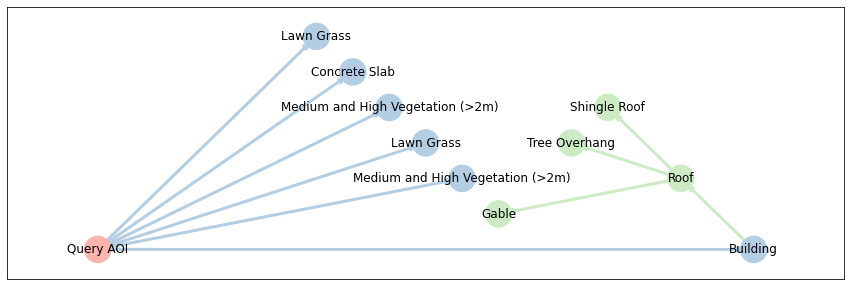

In [11]:
# --- Build a directed acylic graph starting form the query polygon
G = nx.DiGraph()
G.add_node("Parcel", description="Query AOI")
for feature in filtered_features_gdf.itertuples():
    G.add_node(feature.feature_id, description=feature.description, has_parent=feature.parent_id != "")
for feature in filtered_features_gdf.itertuples():
    if feature.parent_id == "":
        G.add_edge("Parcel", feature.feature_id, has_parent=False)
    else:
        G.add_edge(feature.parent_id, feature.feature_id, has_parent=True)

# All nodes should have a description -- if not, the filter step has failed and we have orphan children
assert all("description" in d for _, d in G.nodes(data=True))

# --- Now plot the graph
fig, ax = plt.subplots(figsize=(15, 5))
pos = nx.planar_layout(G)
# nodes
node_color_map = {None: plt.cm.Pastel1(0), False: plt.cm.Pastel1(1), True: plt.cm.Pastel1(2)}
node_color = [node_color_map[d.get("has_parent")] for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=700, margins=0.08, node_color=node_color)
# edges
no_parent_edges = [(u, v) for u, v, d in G.edges(data=True) if not d["has_parent"]]
parent_edges = [(u, v) for u, v, d in G.edges(data=True) if d["has_parent"]]
nx.draw_networkx_edges(
    G, pos, ax=ax, width=3, edge_color=[node_color_map[True]] * len(parent_edges), edgelist=parent_edges
)
nx.draw_networkx_edges(
    G, pos, ax=ax, width=3, edge_color=[node_color_map[False]] * len(no_parent_edges), edgelist=no_parent_edges
)
# labels
nx.draw_networkx_labels(
    G, pos, ax=ax, font_size=12, font_family="sans-serif",
    labels={n: d.get("description", "Error") for n, d in G.nodes(data=True)}
);


# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular format. Note that roof and building values relate to the primary building and roof within a parcel. The primary building is defined as the building with the largest area within the parcel.

In [12]:
df_classes = pd.DataFrame([{"description": "Building"}], index=[constants.BUILDING_ID])
df_classes

,description
a2e4ae39-8a61-5515-9d18-8900aa6e6072,Building


In [13]:
rollup = parcels.feature_attributes(filtered_features_gdf, df_classes, "us", "largest_intersection")
rollup

{'building_present': 'Y',
 'building_count': 1,
 'building_total_area_sqft': 3132,
 'building_total_clipped_area_sqft': 3111,
 'building_total_unclipped_area_sqft': 3132,
 'building_confidence': 0.994140625,
 'primary_building_area_sqft': 3132,
 'primary_building_clipped_area_sqft': 3111,
 'primary_building_unclipped_area_sqft': 3132,
 'primary_building_confidence': 0.994140625,
 'primary_building_has_3d_attributes': 'Y',
 'primary_building_height_ft': 24.7,
 'primary_building_num_storeys_1_confidence': 0.5185629099256127,
 'primary_building_num_storeys_2_confidence': 0.4774573110445819,
 'primary_building_num_storeys_3+_confidence': 0.0039797790298054395}

In [14]:
df_classes  = feature_api.get_feature_classes()
df_classes

,type,internalId,description,schema
id,,,,
0339726f-081e-5a6e-b9a9-42d95c1b5c8a,Feature,1001,Swimming Pool,NaN
0ad1355f-5dfd-403b-8b8b-b7d8ed95731f,Feature,1029,Natural (soft),NaN
19e49dad-4228-554e-9f5e-c2e37b2e11d9,Attribute,8,Building 3d attributes,"{'type': 'object', 'properties': {'classId': {..."
20a58db2-bc02-531d-98f5-451f88ce1fed,Attribute,4,Roof types,"{'type': 'object', 'properties': {'classId': {..."
224f98d3-b853-542a-8b18-e1e46e3a8200,Feature,1016,Flat,NaN
2780fa70-7713-437c-ad98-656b8a5cc4f2,Feature,1026,Low Vegetation (0.5m-2m),NaN
290897be-078b-4948-97aa-755289a67a29,Feature,1031,Concrete Slab,NaN
2e0bd9e3-3b67-4990-84dc-1b4812fdd02b,Feature,1000,Water Body,NaN
3065525d-3f14-5b9d-8c4c-077f1ad5c694,Attribute,10,Roof Condition,"{'type': 'object', 'properties': {'classId': {..."


In [15]:
rollup = parcels.feature_attributes(filtered_features_gdf, df_classes, "us", "largest_intersection")
rollup

{'swimming_pool_present': 'N',
 'swimming_pool_count': 0,
 'swimming_pool_total_area_sqft': 0,
 'swimming_pool_total_clipped_area_sqft': 0,
 'swimming_pool_total_unclipped_area_sqft': 0,
 'swimming_pool_confidence': 1.0,
 'primary_swimming_pool_area_sqft': 0.0,
 'primary_swimming_pool_clipped_area_sqft': 0.0,
 'primary_swimming_pool_unclipped_area_sqft': 0.0,
 'primary_swimming_pool_confidence': 1.0,
 'natural_(soft)_present': 'N',
 'natural_(soft)_count': 0,
 'natural_(soft)_total_area_sqft': 0,
 'natural_(soft)_total_clipped_area_sqft': 0,
 'natural_(soft)_total_unclipped_area_sqft': 0,
 'natural_(soft)_confidence': 1.0,
 'building_3d_attributes_present': 'N',
 'building_3d_attributes_count': 0,
 'building_3d_attributes_total_area_sqft': 0,
 'building_3d_attributes_total_clipped_area_sqft': 0,
 'building_3d_attributes_total_unclipped_area_sqft': 0,
 'building_3d_attributes_confidence': 1.0,
 'primary_building_3d_attributes_area_sqft': 0.0,
 'primary_building_3d_attributes_clipped_are